## Chapter 12, ML Engineering in Action
<b><i>Author: Ben Wilson</i></b><br>
In this notebook, we're following along with Chapter 12, "Holding on to your gains by watching for drift".

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

#### Figure 12.1 Feature Drift

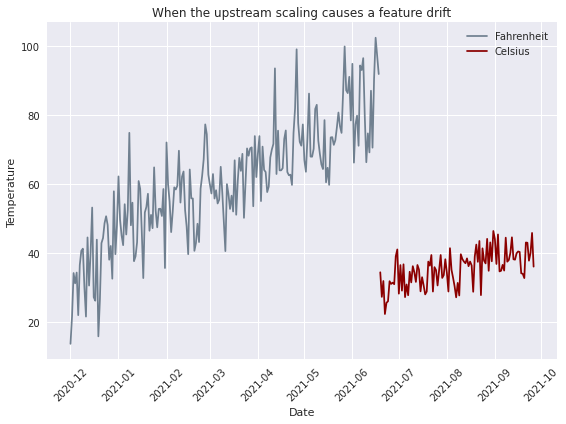

In [2]:
change_dates = datetime(2020,12,1)
date_ranges_f = np.arange(change_dates, 
                        change_dates + timedelta(days=200), 
                        timedelta(days=1)).astype(date)
change_threshold = datetime(2021, 6, 19)
date_ranges_c = np.arange(change_threshold, 
                        change_threshold + timedelta(days=100), 
                        timedelta(days=1)).astype(date)
begin_raw = np.linspace(35, 85, 200) + np.random.normal(loc=0, scale=10, size=200)
change_point_raw = np.linspace(85, 105, 100) + np.random.normal(loc=0, scale=8, size=100)
change_point = np.array([(x - 32) * (5/9) for x in change_point_raw])
begin = np.append(begin_raw, change_point)

with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.plot(date_ranges_f, begin[:200], color='slategrey', label='Fahrenheit')
    ax = plt.plot(date_ranges_c, begin[200:], color='darkred', label='Celsius')
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title("When the upstream scaling causes a feature drift")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('temp_shift.svg', format='svg')

#### Figure 12.2 Label Drift

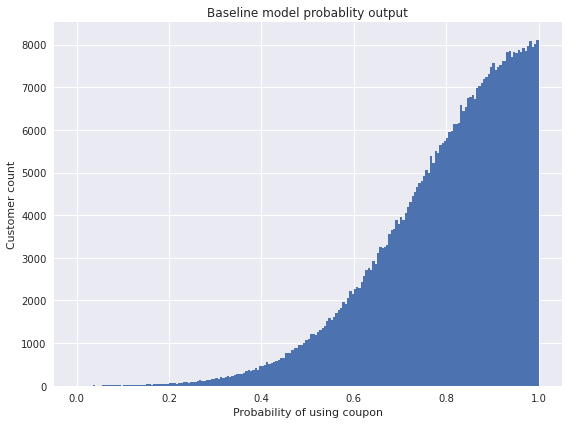

In [3]:
label_pre_raw = (1.0 - np.random.normal(loc=0.5, scale=0.25, size=1000000)) + 0.5
label_pre = label_pre_raw[label_pre_raw <= 1.0]
with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.hist(label_pre, bins=200, range=[0.0, 1.0])
    plt.xlabel('Probability of using coupon')
    plt.ylabel('Customer count')
    plt.title('Baseline model probablity output')
    plt.tight_layout()
    plt.savefig('label_pre_drift.svg', format='svg')

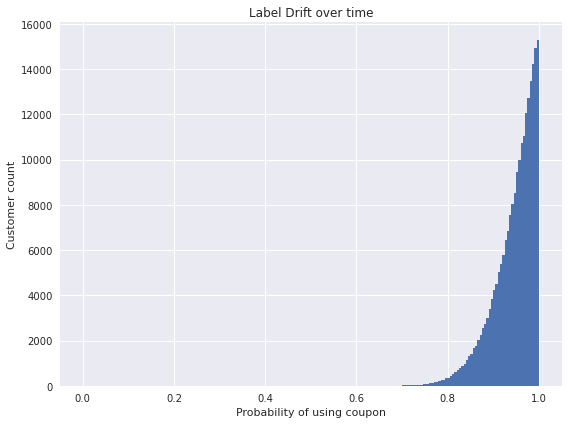

In [4]:
label_post_raw = (1.0 - np.random.normal(loc=0.9, scale=0.1, size=1200000))  + 0.99
label_post = label_post_raw[label_post_raw <= 1.0]
with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.hist(label_post, bins=200, range=[0.0, 1.0])
    plt.xlabel('Probability of using coupon')
    plt.ylabel('Customer count')
    plt.title('Label Drift over time')
    plt.tight_layout()
    plt.savefig('label_drift.svg', format='svg')

#### Figure 12.4 Prediction Drift

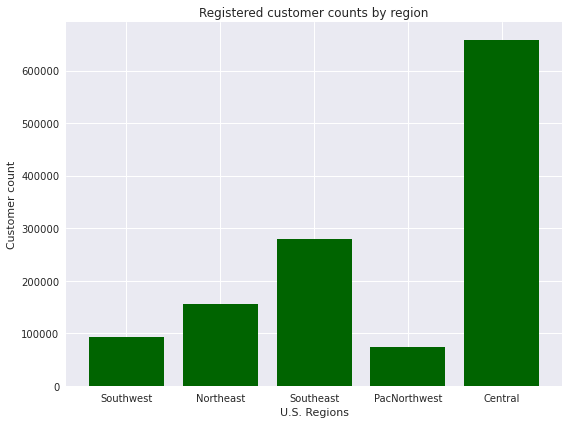

In [5]:
prior_region = {'Southwest': 92511, 'Northeast': 155123, 'Southeast': 278933, 
                'PacNorthwest': 73445, 'Central': 658743}
post_region = {'Southwest': 98511, 'Northeast': 179123, 'Southeast': 294933, 
                'PacNorthwest': 598739, 'Central': 698842}
region_size = range(len(prior_region))

with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.bar(region_size, list(prior_region.values()), align='center', color='darkgreen')
    plt.xticks(region_size, list(prior_region.keys()))
    plt.xlabel('U.S. Regions')
    plt.ylabel('Customer count')
    plt.title('Registered customer counts by region')
    plt.tight_layout()
    plt.savefig('customer_region_counts_pre.svg', format='svg')

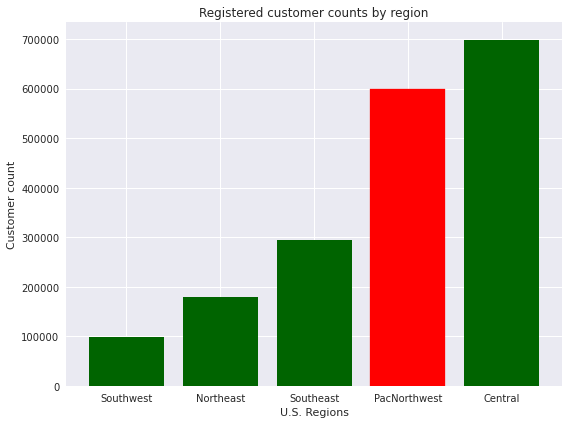

In [6]:
with plt.style.context(style='seaborn'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.bar(region_size, list(post_region.values()), align='center', color='darkgreen')
    ax[3].set_color('r')
    plt.xticks(region_size, list(post_region.keys()))
    plt.xlabel('U.S. Regions')
    plt.ylabel('Customer count')
    plt.title('Registered customer counts by region')
    plt.tight_layout()
    plt.savefig('customer_region_counts_post.svg', format='svg')

#### Figure 12.5 Drift monitoring

In [7]:
full_dates = np.append(date_ranges_f, date_ranges_c)
temp_shift_df = pd.DataFrame(data=begin, columns=['temp'])
temp_shift_df['date'] = full_dates

def basic_shift_example(data, field, window=7, sigma=3):
    roll_mean = 'rolling_mean_{}'.format(field)
    roll_std = 'rolling_std_{}'.format(field)
    data[roll_mean] = data[field].rolling(window).mean()
    data[roll_std] = data[field].rolling(window).std()
    data['upper_bound_{}'.format(field)] = data[roll_mean] + (data[roll_std] * sigma)
    data['lower_bound_{}'.format(field)] = data[roll_mean] - (data[roll_std] * sigma)
    return data

def plot_basic_alert_chart(data, field, name, window=7, sigma=3, figsize=(8,7)):
    plotting_df = basic_shift_example(data, field, window, sigma)
    with plt.style.context(style='seaborn'):
        fig = plt.figure(figsize=figsize)
        ax = plt.plot(plotting_df['date'], plotting_df[field], color='slategrey', label=field)
        ax = plt.plot(plotting_df['date'], 
                      plotting_df['rolling_mean_{}'.format(field)], 
                      color='darkgreen', linestyle='--', label='Rolling Mean')
        ax = plt.plot(plotting_df['date'], 
                      plotting_df['upper_bound_{}'.format(field)], 
                      color='red', linestyle='-.', label='Boundaries')
        ax = plt.plot(plotting_df['date'], 
                      plotting_df['lower_bound_{}'.format(field)], 
                      color='red', linestyle='-.')
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.ylabel('Temperature')
        plt.title("When the upstream scaling causes a feature drift")
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig('alerting_{}.svg'.format(field), format='svg')

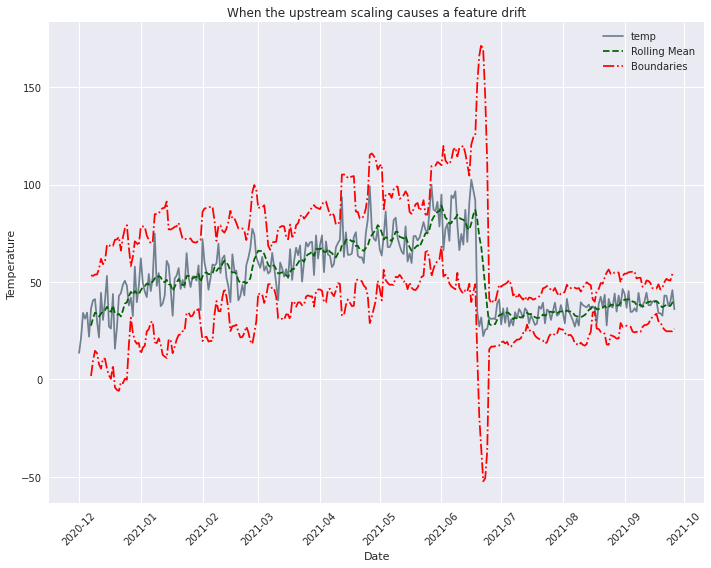

In [8]:
plot_basic_alert_chart(temp_shift_df, 'temp', 'temp_shift', 7, 3, (10,8))